<a href="https://colab.research.google.com/github/Schiessl/AgoraVAI/blob/main/Markowitz_Teoria_Moderna_de_Portfolio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Instalando e importando bibliotecas

Caso queira rodar todo programa de uma vez, aperte CTRL+F9

In [99]:
!pip install -U pandas_datareader
!pip install -U yfinance
!pip install -U investpy
!pip install -q mplfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [100]:
import pandas as pd
import pandas_datareader as pdr
import yfinance as yf
import investpy
import mplfinance as mpf
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy as sco 
from scipy import stats
import matplotlib.ticker as mtick
from datetime import date, datetime, timedelta
import yfinance as yf
yf.pdr_override()

#2. Definindo o período e lista de ativos

In [101]:
######################################################################
######################################################################
qtde_anos = 5
######################################################################
######################################################################
today = date.today()
data_hoje = today.strftime("%d/%m/%Y") # data de hoje em formato brasileiro
date_today = today.strftime("%Y-%m-%d")  # data de hoje em formato brasileiro
inicio = datetime.now() + timedelta(days=(-365.25*qtde_anos)) # data inicial volta para 'qtde_anos' anos atrás
data_inicio = inicio.strftime("%d/%m/%Y")  # data de hoje em formato brasileiro
date_start = inicio.strftime("%Y-%m-%d") # data de hoje em formato amerciano
print("Data Início: ", data_inicio, '\n' "Data Fim: ", data_hoje)
print("Start Date: ", date_start, '\n' "End Date: ", date_today)

Data Início:  17/05/2018 
Data Fim:  17/05/2023
Start Date:  2018-05-17 
End Date:  2023-05-17


### Entrar com os ativos com '.SA'

In [102]:
######################################################################
######################################################################
tickers = ['EGIE3.SA', 'ITSA4.SA', 'VIVT3.SA', 'BBDC4.SA', 'SBSP3.SA','PETR4.SA', 'VALE3.SA']
# tickers = ['EGIE3.SA', 'ITSA4.SA', 'VIVT3.SA', 'BBDC4.SA', 'SBSP3.SA']
######################################################################
######################################################################

#3. Importando histórico de ações

In [103]:
precos = pd.DataFrame()

for i in tickers:
  ticker = yf.Ticker(i)
  precos[i] = ticker.history()["Close"]


###Renomeando colunas

In [104]:
novo_nome = []
for i in range(len(tickers)):
  elemento = str(tickers[i][:tickers[i].find('.SA')]) # elimina o '.SA'
  novo_nome.append(elemento)

precos.columns = novo_nome
# precos.head()

### Reduzindo a mesma escala
Transformando o histórico para base 100

In [105]:
preco_100 = (precos/precos.iloc[0]*100) # trava no primeiro registro da série
# preco_100.head()

### Gráfico do histórico

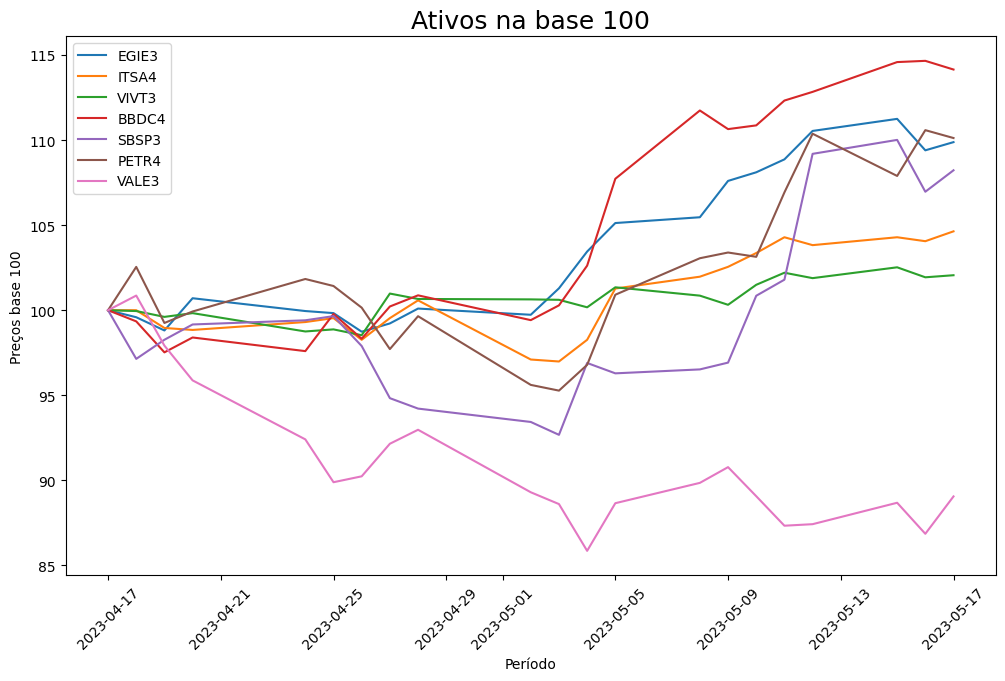

In [106]:
df = preco_100
fig, ax = plt.subplots(figsize=[12, 7])

for col in df.columns:
  plt.plot(df[col], label=col) # label com a coluna do dataframe

plt.xticks(rotation=45)
ax.set_title('Ativos na base 100', fontsize=18)
ax.set_xlabel('Período')
ax.set_ylabel('Preços base 100')
plt.legend()
plt.show()

#4. Estimar retornos, volatilidade e covariância

$$ Retorno = \frac{(preço_t -preço_{t-1})}{preço_{t-1}} $$
ou
$$ Retorno = \frac{preço_t}{preço_{t-1}}-1 $$

In [107]:
retornos = precos.pct_change().dropna() # retirar registros com 'NaN'
rotulo= retornos.columns.to_list()
e_r=retornos.mean()
vol=retornos.std()
mat_cov=retornos.cov()
#matriz_cov
# retornos
# rotulo # para utilizar nos gráficos

In [108]:
retornos = precos.pct_change().dropna()

retornos.head()

,EGIE3,ITSA4,VIVT3,BBDC4,SBSP3,PETR4,VALE3
Date,,,,,,,
2023-04-18 00:00:00-03:00,-0.004127,0.000000,-0.000490,-0.006555,-0.028595,0.025459,0.008604
2023-04-19 00:00:00-03:00,-0.007801,-0.010429,-0.003429,-0.018328,0.011564,-0.032128,-0.029157
2023-04-20 00:00:00-03:00,0.019165,-0.001171,0.002212,0.008962,0.009146,0.006790,-0.020852
2023-04-24 00:00:00-03:00,-0.007474,0.004689,-0.010790,-0.008142,0.002472,0.019108,-0.036164
2023-04-25 00:00:00-03:00,-0.001214,0.002334,0.001239,0.022388,0.002466,-0.004044,-0.027237


In [109]:
retornos = np.log(precos/precos.shift(1)).dropna()
retornos.head()

,EGIE3,ITSA4,VIVT3,BBDC4,SBSP3,PETR4,VALE3
Date,,,,,,,
2023-04-18 00:00:00-03:00,-0.004136,0.000000,-0.000490,-0.006577,-0.029011,0.025140,0.008567
2023-04-19 00:00:00-03:00,-0.007832,-0.010484,-0.003435,-0.018499,0.011498,-0.032656,-0.029591
2023-04-20 00:00:00-03:00,0.018983,-0.001172,0.002209,0.008922,0.009104,0.006767,-0.021073
2023-04-24 00:00:00-03:00,-0.007502,0.004678,-0.010848,-0.008175,0.002469,0.018928,-0.036834
2023-04-25 00:00:00-03:00,-0.001215,0.002331,0.001239,0.022141,0.002463,-0.004052,-0.027615


#5. Geração de portfolios

###Definir a quantidade de portfólios que serão gerados

In [110]:
#######################################################################
######################################################################
# Entre com a quantidade de portfolios
n_portfolios=1000
######################################################################
######################################################################

In [111]:
p_ret=[]
p_vol=[]
p_pesos=[]

n_ativos=len(retornos.columns)  # Quantidade de ativos

for portfolios in range(n_portfolios):
  pesos=np.random.random(n_ativos) # Pesos aleatórios
  pesos=pesos/np.sum(pesos) # Pesos que somam 1
  p_pesos.append(pesos)

  returns=np.dot(pesos,e_r) # Retornos
  p_ret.append(returns)

  var=mat_cov.mul(pesos, axis=0).mul(pesos, axis=1).sum().sum() # Covariância
  dp=np.sqrt(var) # Desvio Padrão
  p_vol.append(dp)

p_ret=np.array(p_ret)
p_vol=np.array(p_vol)
dados={'Retorno':p_ret, 'Risco':p_vol}
portfolios=pd.DataFrame(dados)
#portfolios

###Gráfico de porfólios gerados

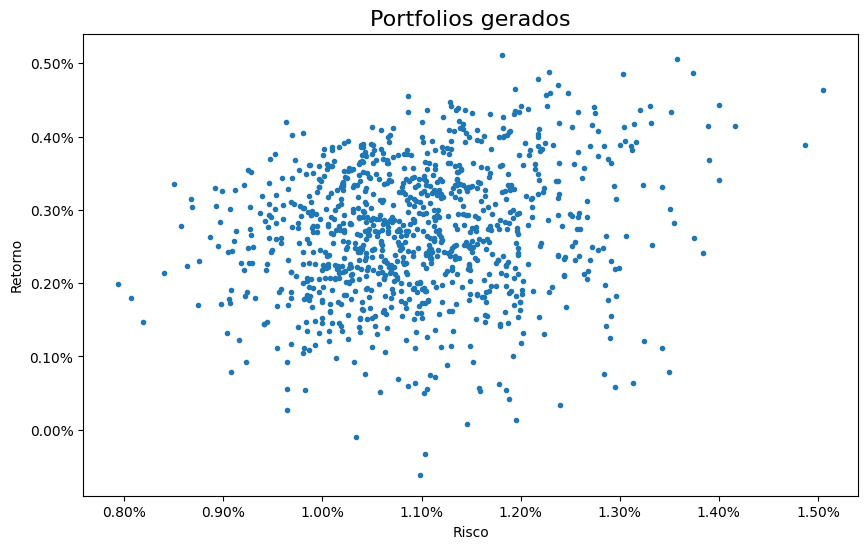

In [112]:
plt.figure(figsize=(10,6))
plt.scatter(portfolios['Risco'],portfolios['Retorno'], marker='.')
plt.title('Portfolios gerados', fontsize=16)
plt.xlabel('Risco')
plt.ylabel('Retorno')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

##Portfólios com Sharpe

#### Ativo Livre de Risco 
Estou utilizando a taxa SELIC, mas o usuário pode escolher outra taxa 

Conversão a taxa anual em diária

$$ tx_{dia}  = (tx_{ano} + 1)^{(1/252)}-1 $$
ou\
$$ tx_{dia}  = \sqrt[252]{tx_{ano}} - 1 $$

In [113]:
######################################################################
######################################################################
tx=0.08
######################################################################
######################################################################
rf = ((tx + 1)**(1/252))-1
print('Taxa livre de risco diária: ', '{:.2%}'.format(rf))

Taxa livre de risco diária:  0.03%


##Carteira de Menor Risco
Menor volatilidade

###Definição das funções para definir retorno e risco


In [114]:
def port_ret(pesos): #Função de cálculo de retorno
  return np.sum(e_r*pesos)

def port_vol(pesos): #Função de cálculo de risco
  return math.sqrt(np.dot(pesos,np.dot(mat_cov, pesos))) # Lembrar que o np.dot ignora o .T de transposição do vetor. Sempre faz a multiplicação automática, isto é, transpõe se necessário for.

###Definição de restrições da função
Caso não queira que a alocação seja 0% ou 100% em algum ativo, mude o parâmetro de tuple(0,1)

In [115]:
######################################################################
######################################################################
tpl1 = 0.0     # limite mínimo de alocação
tpl2 = 1-tpl1   # limite máximo de alocação
######################################################################
######################################################################
restri = ({'type':'eq','fun':lambda x: np.sum(x)-1}) # A soma dos pesos é 1
bnds=tuple((tpl1,tpl2) for x in range(n_ativos)) # Gera uma tupla de (tpl1,tpl1) para cada ativo
pesos_i=np.array(n_ativos*[1/n_ativos]) # Inicia com pesos iguais para todos os ativos
# pesos_i
# bnds

###Otimização da Carteira
Distribuição de pesos no ponto ótimo de menor volatilidade

In [116]:
otim_menor_vol=sco.optimize.minimize(port_vol, pesos_i, method='SLSQP', bounds=bnds, constraints=restri)
# otim_menor_vol

###Pesos otimizados com menor risco


In [117]:
peso_otimo = otim_menor_vol['x'].round(2)
ret_otimo = port_ret(otim_menor_vol['x'])
vol_otimo = port_vol(otim_menor_vol['x'])

print('Rótulos: ', rotulo,'\n',
      'Pesos  da carteira de menor risco:', peso_otimo,'\n',
      'Retorno da carteira de menor risco: ', '{:.2%}'.format(ret_otimo),'\n',
      'Risco da carteira de menor risco: ', '{:.2%}'.format(vol_otimo))

Rótulos:  ['EGIE3', 'ITSA4', 'VIVT3', 'BBDC4', 'SBSP3', 'PETR4', 'VALE3'] 
 Pesos  da carteira de menor risco: [0.13 0.   0.72 0.   0.06 0.1  0.  ] 
 Retorno da carteira de menor risco:  0.21% 
 Risco da carteira de menor risco:  0.66%


##Fronteira Eficiente

###Estimação da fronteira eficiente

In [118]:
cons = ({'type':'eq','fun':lambda x: port_ret(x) - tret},{'type':'eq','fun':lambda x: np.sum(x)-1})
trets=np.linspace(p_ret.min(),p_ret.max(),50)
tvols=[]

for tret in trets:
  res = sco.optimize.minimize(port_vol,pesos_i,method='SLSQP',bounds=bnds, constraints=cons)
  tvols.append(res['fun'])

tvols=np.array(tvols)
# tvols

###Gráfico da fronteira eficiente com a carteira de menor risco
Cores baseadas no Índice Sharpe

$${\displaystyle IS={\frac {{\textsf {E}}[R-R_{f}]}{\sigma }}}$$

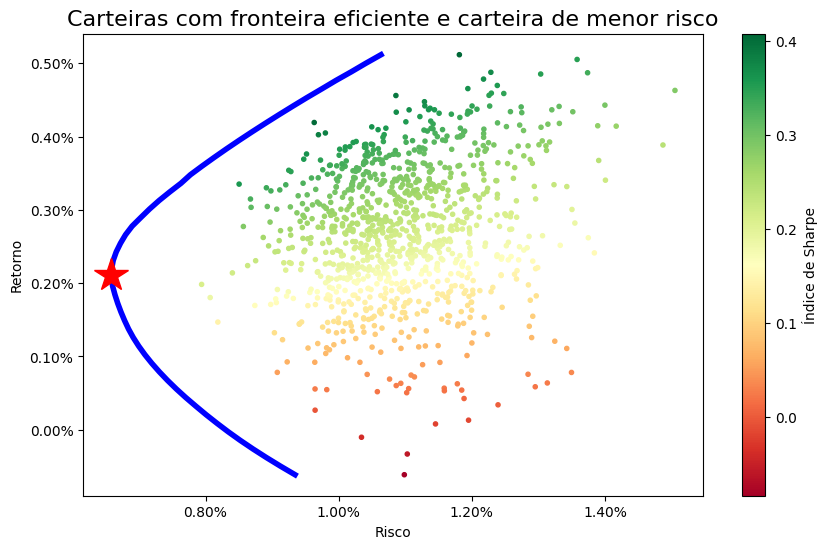

In [119]:
#Gráfico da Fronteira Eficiente e carteira de menor volatilidade (template de cores: PiYG, viridis, RdYlGn)
plt.figure(figsize=(10,6))
plt.scatter(p_vol,p_ret, c=(p_ret-rf)/p_vol, marker='.', cmap='RdYlGn')
plt.plot(tvols,trets,'b', lw=4)
plt.plot(port_vol(otim_menor_vol['x']), port_ret(otim_menor_vol['x']),'r*', markersize=25)
plt.title('Carteiras com fronteira eficiente e carteira de menor risco', fontsize=16)
plt.xlabel('Risco')
plt.ylabel('Retorno')
plt.colorbar(label='Índice de Sharpe')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

###Gráfico da alocação ótima da carteira de menor risco

In [120]:
import matplotlib.font_manager

font_list = matplotlib.font_manager.findSystemFonts()
print(font_list)


['/usr/share/fonts/truetype/liberation/LiberationMono-BoldItalic.ttf', '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Italic.ttf', '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf', '/usr/share/fonts/truetype/humor-sans/Humor-Sans.ttf', '/usr/share/fonts/truetype/liberation/LiberationSerif-BoldItalic.ttf', '/usr/share/fonts/truetype/liberation/LiberationSerif-Bold.ttf', '/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf', '/usr/share/fonts/truetype/liberation/LiberationSerif-Italic.ttf', '/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf', '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-BoldItalic.ttf', '/usr/share/fonts/truetype/liberation/LiberationSans-Bold.ttf', '/usr/share/fonts/truetype/liberation/LiberationMono-Italic.ttf', '/usr/share/fonts/truetype/liberation/LiberationSerif-Regular.ttf', '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Bold.ttf', '/usr/share/fonts/truetype/liberation/LiberationMon

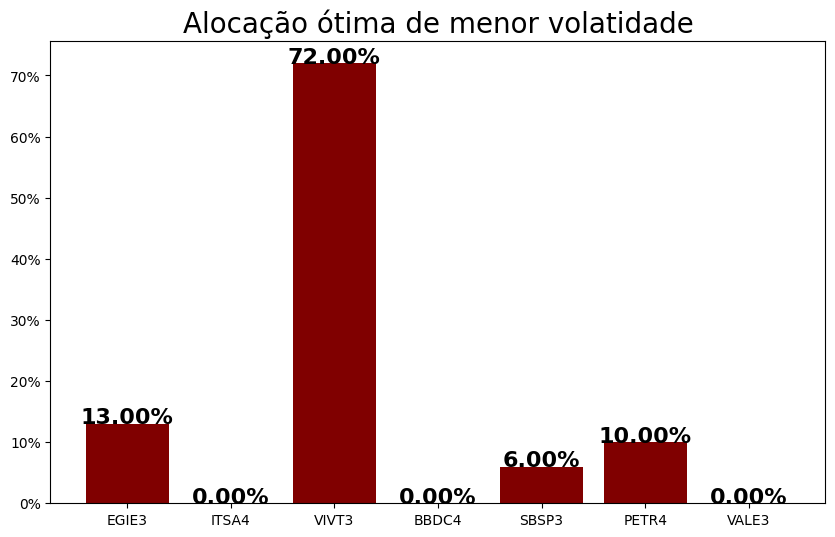

In [121]:
x=rotulo
y=peso_otimo

# definir fonte
# font = {'family' : 'LiberationSans', 'weight' : 'bold', 'size' : 16}
font = {'weight' : 'bold', 'size' : 16}

# função para adicionar valor das barras
def addlabels(x,y):
    for i in range(len(x)):
#        plt.text(i,y[i],y[i], ha = 'center')
        plt.text(i, y[i], '{:.2%}'.format(y[i]), ha = 'center', **font )

fig, ax =plt.subplots(figsize=(10,6))

#Faz o gráfico de barras
plt.bar(x, y, color='maroon' )

# chama a função para adicionar valor nas barras
addlabels(x, y)
# adiciona título
plt.title('Alocação ótima de menor volatidade', fontsize= 20)
# transforma eixo y em percentual
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))


## Carteira de Índice Sharpe máximo

In [122]:
# Estimar carteira de Sharpe Ratio máximo
def min_func_sharpe(pesos):
  return -(port_ret(pesos)-rf)/port_vol(pesos)

# Otimização do Sharpe
otim_sharpe=sco.optimize.minimize(min_func_sharpe, pesos_i, method='SLSQP', bounds=bnds, constraints=restri)

In [123]:
peso_otimo = otim_sharpe['x'].round(2)
ret_otimo = port_ret(otim_sharpe['x'])
vol_otimo = port_vol(otim_sharpe['x'])

print('Rótulos: ', rotulo,'\n',
      'Pesos  da carteira de maior sharpe:', peso_otimo,'\n',
      'Retorno da carteira de maior sharpe: ', '{:.2%}'.format(ret_otimo),'\n',
      'Risco da carteira de maior sharpe: ', '{:.2%}'.format(vol_otimo))

Rótulos:  ['EGIE3', 'ITSA4', 'VIVT3', 'BBDC4', 'SBSP3', 'PETR4', 'VALE3'] 
 Pesos  da carteira de maior sharpe: [0.67 0.   0.   0.3  0.   0.03 0.  ] 
 Retorno da carteira de maior sharpe:  0.54% 
 Risco da carteira de maior sharpe:  1.12%


###Gráfico da Fronteira Eficiente com carteira de Sharpe máximo

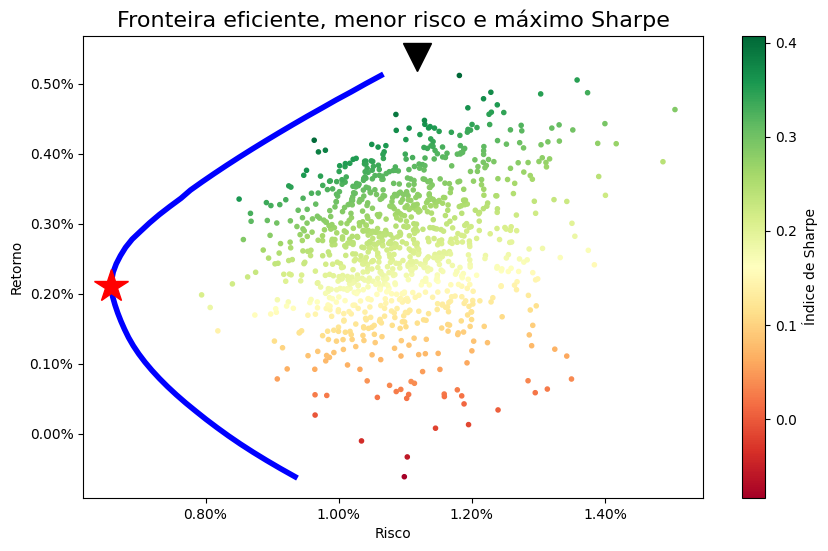

In [124]:
plt.figure(figsize=(10,6))
plt.scatter(p_vol,p_ret, c=(p_ret-rf)/p_vol, marker='.', cmap='RdYlGn')
plt.plot(tvols,trets,'b', lw=4)
plt.plot(port_vol(otim_sharpe['x']), port_ret(otim_sharpe['x']),'kv', markersize=20) # Máximo Sharpe
plt.plot(port_vol(otim_menor_vol['x']), port_ret(otim_menor_vol['x']),'r*', markersize=25) # Menor Risco
plt.title('Fronteira eficiente, menor risco e máximo Sharpe', fontsize=16)
plt.xlabel('Risco')
plt.ylabel('Retorno')
plt.colorbar(label='Índice de Sharpe')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

###Alocação ótima da carteira de Sharpe máximo


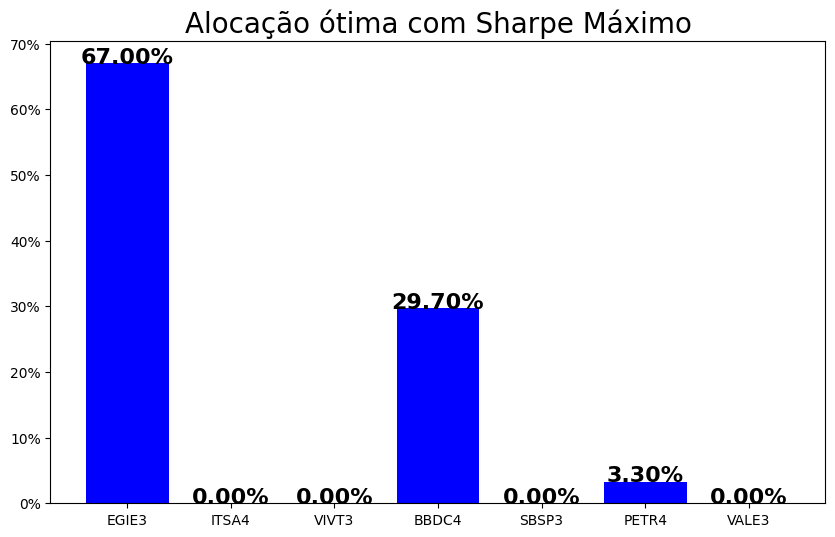

In [125]:
x=rotulo
y=otim_sharpe['x'].round(3)

# definir fonte
font = {'weight' : 'bold', 'size' : 16}

# função para adicionar valor das barras
def addlabels(x,y):
    for i in range(len(x)):
#        plt.text(i,y[i],y[i], ha = 'center')
        plt.text(i, y[i], '{:.2%}'.format(y[i]), ha = 'center', **font )

fig, ax =plt.subplots(figsize=(10,6))

#Faz o gráfico de barras
plt.bar(x, y, color='blue' )

# chama a função para adicionar valor nas barras
addlabels(x, y)
# adiciona título
plt.title('Alocação ótima com Sharpe Máximo', fontsize= 20)
# transforma eixo y em percentual
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

## Linha de Alocação de Capital - CAL

###Nível de aversão ao risco do usuário
Quanto menor o parâmetro, maior a aversão ao risco do investidor 

In [126]:
######################################################################
######################################################################
a = 5 # Definir o nível de aversão - quanto menor, maior aversão
######################################################################
######################################################################

In [127]:
eixo_x=[]
eixo_y=[]
utility=[]

for er in np.linspace(rf,max(trets),20):
  sd=(er-rf)/((port_ret(otim_sharpe['x'])-rf)/port_vol(otim_sharpe['x']))
  u = er -0.5*a*(sd**2)
  eixo_x.append(sd)
  eixo_y.append(er)
  utility.append(u)

data3={'Utilidade':utility,'Retorno':eixo_y,'Risco':eixo_x}
cal = pd.DataFrame(data3)

###Estimar Carteira Ótima Completa

In [128]:
wp = (port_ret(otim_sharpe['x'])-rf)/(a*port_vol(otim_sharpe['x'])**2)
r_oc = wp*port_ret(otim_sharpe['x'])+(1-wp)*rf
v_oc = wp*port_vol(otim_sharpe['x'])
wp

8.137879788889508

###Gráfico da Fronteira Eficiente com CAL e Alocação Ótima

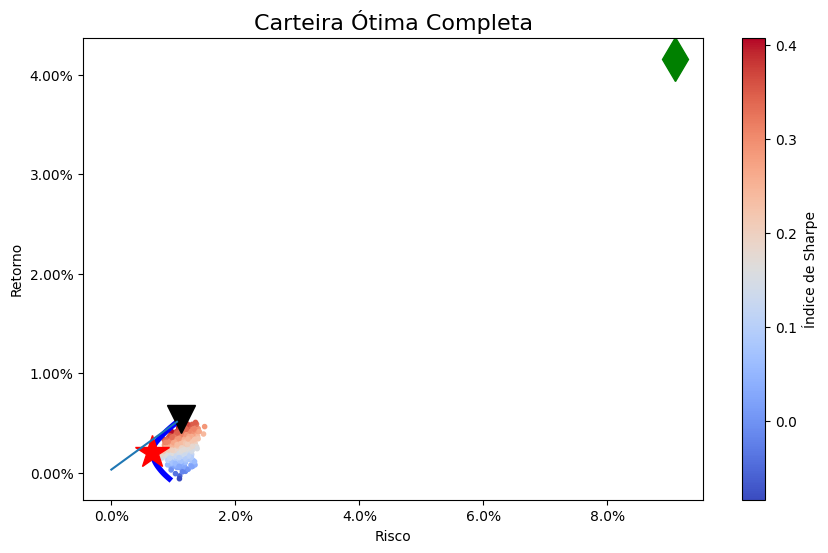

In [129]:
plt.figure(figsize=(10,6))
plt.scatter(p_vol,p_ret, c=(p_ret-rf)/p_vol, marker='.', cmap='coolwarm')
plt.plot(tvols,trets,'b', lw=4)
plt.plot(port_vol(otim_sharpe['x']), port_ret(otim_sharpe['x']),'kv', markersize=20)
plt.plot(port_vol(otim_menor_vol['x']), port_ret(otim_menor_vol['x']),'r*', markersize=25)
plt.plot(v_oc,r_oc,'gd ', markersize=22)
plt.plot(eixo_x,eixo_y)
plt.title('Carteira Ótima Completa', fontsize=16)
plt.xlabel('Risco')
plt.ylabel('Retorno')
plt.colorbar(label='Índice de Sharpe')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))


### Arranjo de listas para juntar a carteira com renda fixa

In [130]:
p_arr = otim_sharpe['x']
lst_num = p_arr.tolist()
p_s = []
p_tmp = 1-wp

for i in lst_num:
  p_s.append(i*p_tmp) # contemplar a proporção de ativo livre de risco

p_s.append(wp)

rotulo_rf= retornos.columns.to_list()
rotulo_rf.append('Renda Fixa')
#rotulo
#p_s
#otim_sharpe

In [131]:
formattedList = ["%.2f" % member for member in p_s]
print('##### Resultado Final da Carteira Otimizada #####', '\n',
      rotulo_rf,'\n',
      formattedList)

##### Resultado Final da Carteira Otimizada ##### 
 ['EGIE3', 'ITSA4', 'VIVT3', 'BBDC4', 'SBSP3', 'PETR4', 'VALE3', 'Renda Fixa'] 
 ['-4.78', '-0.00', '-0.00', '-2.12', '-0.00', '-0.24', '-0.00', '8.14']


###Alocação Ótima da Carteira Completa

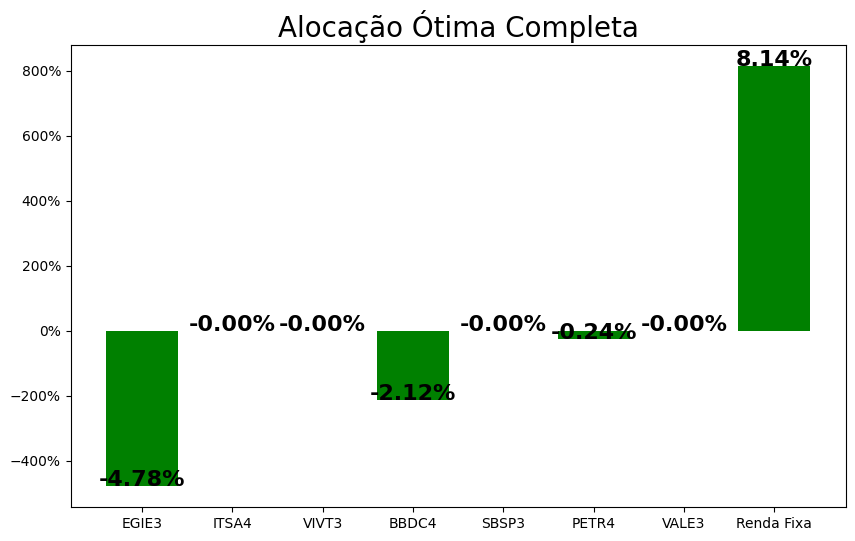

In [132]:
x=rotulo_rf
y=p_s
#peso_otimo

# definir fonte
font = {'weight' : 'bold', 'size'   : 16}

# função para adicionar valor das barras
def addlabels(x,y):
    for i in range(len(x)):
#        plt.text(i,y[i],y[i], ha = 'center')
        # plt.text(i, y[i], '{:.2%}'.format(y[i]), ha = 'center', **font )
        plt.text(i, y[i], '{:.2%}'.format(y[i]/100), ha = 'center', **font )

fig, ax =plt.subplots(figsize=(10,6))

#Faz o gráfico de barras
plt.bar(x, y, color='green' )

# chama a função para adicionar valor nas barras
addlabels(x, y)
# adiciona título
plt.title('Alocação Ótima Completa', fontsize= 20)
# transforma eixo y em percentual
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))